In [ ]:
!pip install fastparquet
# !pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 7.1 MB/s 
     |████████████████████████████████| 12.2 MB 58.8 MB/s 
     |████████████████████████████████| 2.0 MB 30.8 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR="/content/drive/MyDrive/capstone-crypto-team4/Data"


Mounted at /content/drive


# clean and calculate sentiment for each reddit post/comment

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import fastparquet
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('omw-1.4')

from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

from textblob import TextBlob
from tqdm import tqdm

SIA = SentimentIntensityAnalyzer()

COL_POST = ['id', 'epoch', 'date', 'title', 'selftext']
COL_COMM = ['id', 'epoch', 'date', 'body']


class RedditText:
  def __init__(self, data_path, save_path, start_date, end_date, stopwords, cryptowords):
    self.post = fastparquet.ParquetFile(data_path + "/posts.parquet")
    self.comment = fastparquet.ParquetFile(data_path + "/comments.parquet")
    self.save_path = save_path
    self.dates = pd.date_range(start_date, end_date)
    self.stopwords = stopwords
    self.cryptowords = cryptowords

  def run(self):
    bar = tqdm(self.dates)
    for dt in bar:
      bar.set_description(str(dt.date()))
      df_post = self.post.to_pandas(filters=[('date', '==', dt.date())], columns=COL_POST)
      # if len(df_post) > 0:
      df_post = df_post[COL_POST]
      df_post.rename(columns={'selftext': 'text'}, inplace=True)
      df_post.loc[:, 'text'] = df_post.loc[:, 'title'] + ' ' + df_post.loc[:, 'text']
      df_post.drop('title', axis=1, inplace=True)
      df_comm = self.comment.to_pandas(filters=[('date', '==', dt.date())], columns=COL_COMM)
      # if len(df_comm) > 0:
      df_comm = df_comm[COL_COMM]
      df_comm.rename(columns={'body': 'text'}, inplace=True)

      df = pd.concat([df_post, df_comm], axis=0, ignore_index=True)
      if len(df) == 0:
        continue
      df = df[df.text.apply(lambda x: "I'm a bot" not in x)]
      df['text'] = df['text'].apply(self.text_clean1)
      df = df[df.text != '']
      df = df[df.text.apply(lambda x: len(x.split(' '))) > 3]
      

      df['polarity'] = df.text.apply(self.text_clean2).apply(lambda x: SIA.polarity_scores(x)['compound'])
      df.sort_values('epoch', inplace=True)

      if os.path.exists(os.path.join(self.save_path, f"reddit_clean.parquet")):
        fastparquet.write(
          os.path.join(self.save_path, f"reddit_clean.parquet"), df,
          compression="snappy",
          # file_scheme='hive',
          write_index=False,
          # partition_on=["date"],
          append=True
        )
      else:
        fastparquet.write(
          os.path.join(self.save_path, f"reddit_clean.parquet"), df,
          compression="snappy",
          # file_scheme='hive',
          write_index=False,
          # partition_on=["date"]
        )

  def text_clean1(self, text):
    # I.
    # 1. Remove urls/hyperlinks
    text = re.sub(r'((www\.[^\s]+)|(http\S+))', 'linktag', text)
    # 2. Remove hashtags
    text = re.sub(r'#\w+', 'hashtags', text)
    # 3. Remove mentions
    text = re.sub(r'@\w+', 'mentions', text)
    # 4. Remove characters that not in the English alphabets
    text = re.sub('[^A-Za-z.,?!]+', ' ', text)
    # 5. Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)

    text = text.lower()

    return text.strip()

  def text_clean2(self, text):
    # II.
    # 1. Tokenize
    text = TweetTokenizer().tokenize(text)
    # 2. Remove Puncs
    text = [w for w in text if w.isalpha()]
    # 3. Removing Stopwords
    lemmatizer = WordNetLemmatizer()
    # Import nltk stopwords and customize it to add common crypto words that don't add too much information
    text = [t for t in text if t not in (self.stopwords + self.cryptowords)]
    # 4. lemmatize
    text = [lemmatizer.lemmatize(t) for t in text]
    # 5. Joining
    text = ' '.join(text)
    text = text.strip().strip()

    return text


# if __name__ == '__main__':
#     # x = RedditText('./reddit/', './reddit/', '2017-12-01', '2018-12-31', stopwords.words(['english']), [])
#     x = RedditText('./reddit/', './reddit/', '2019-01-01', '2020-12-31', stopwords.words(['english']), [])
#     x.run()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
x1 = RedditText(DATA_DIR+'/reddit/', DATA_DIR+'/reddit/', '2017-12-01', '2018-12-31', stopwords.words(['english']), [])
x2 = RedditText(DATA_DIR+'/reddit/', DATA_DIR+'/reddit/', '2019-01-01', '2020-12-31', stopwords.words(['english']), [])
x3 = RedditText(DATA_DIR+'/reddit/', DATA_DIR+'/reddit/', '2021-01-01', '2022-11-30', stopwords.words(['english']), [])

In [ ]:
x1.run()
x2.run()

2020-12-31: 100%|██████████| 731/731 [53:21<00:00,  4.38s/it]


In [ ]:
x3.run()

2022-11-30: 100%|██████████| 598/598 [2:22:12<00:00, 14.27s/it]


********

# aggregate sentiment to different freq

In [ ]:
import pandas as pd
import fastparquet

In [ ]:
f = fastparquet.ParquetFile(DATA_DIR+'/reddit/reddit_clean.parquet')
f.info

{'name': '/content/drive/MyDrive/capstone-crypto-team4/Data/reddit/reddit_clean.parquet',
 'columns': ['id', 'epoch', 'date', 'text', 'polarity'],
 'partitions': [],
 'rows': 11344184,
 'row_groups': 1810}

In [ ]:
df = f.to_pandas(columns=['epoch', 'polarity'])
df.shape

(11344184, 2)

In [ ]:
df['datetime'] = pd.to_datetime(df.epoch, unit='s')
df.set_index('datetime', inplace=True)
df.drop('epoch', axis=1, inplace=True)
df.head()

,polarity
datetime,
2017-12-01 00:00:11,-0.3384
2017-12-01 00:00:43,0.0000
2017-12-01 00:00:48,-0.7783
2017-12-01 00:00:59,-0.9322
2017-12-01 00:01:19,0.0000


In [ ]:
df.head(300).polarity.resample('1min', label='right', closed='right', origin='start_day').agg(
      ['mean', 'sum', 'std']
  )

datetime
2017-12-01 00:00:11   -0.3384
2017-12-01 00:00:43    0.0000
2017-12-01 00:00:48   -0.7783
2017-12-01 00:00:59   -0.9322
2017-12-01 00:01:19    0.0000
                        ...  
2017-12-01 01:03:04    0.0000
2017-12-01 01:03:04    0.0000
2017-12-01 01:03:35    0.2960
2017-12-01 01:03:56    0.0000
2017-12-01 01:05:18    0.3182
Name: polarity, Length: 300, dtype: float64

In [ ]:
def change_freq(df, freq):
  df = df.resample(freq, label='right', closed='right', origin='start_day').agg(
      ['mean', 'sum', 'std', 'count']
  )
  df = df.fillna(0)
  return df

In [ ]:
df_1min = change_freq(df.polarity, '1min')
df_5min = change_freq(df.polarity, '5min')
df_10min = change_freq(df.polarity, '10min')
df_30min = change_freq(df.polarity, '30min')
df_60min = change_freq(df.polarity, '60min')


In [ ]:
df_1min.to_pickle(DATA_DIR+'/reddit/reddit_senti_1min.pkl')
df_5min.to_pickle(DATA_DIR+'/reddit/reddit_senti_5min.pkl')
df_10min.to_pickle(DATA_DIR+'/reddit/reddit_senti_10min.pkl')
df_30min.to_pickle(DATA_DIR+'/reddit/reddit_senti_30min.pkl')
df_60min.to_pickle(DATA_DIR+'/reddit/reddit_senti_60min.pkl')

In [ ]:
df_5min#..plot()

,mean,sum,std,count
datetime,,,,
2017-12-01 00:05:00,-0.086905,-1.6512,0.467935,19
2017-12-01 00:10:00,0.199371,4.1868,0.479799,21
2017-12-01 00:15:00,0.124510,2.6147,0.467985,21
2017-12-01 00:20:00,0.070239,2.1774,0.507207,31
2017-12-01 00:25:00,0.375936,10.5262,0.471469,28
...,...,...,...,...
2022-11-30 23:40:00,0.260518,2.8657,0.281472,11
2022-11-30 23:45:00,0.086025,0.6882,0.447358,8
2022-11-30 23:50:00,0.445136,4.8965,0.289753,11


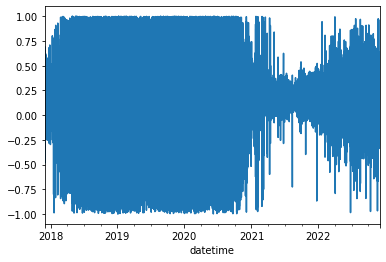

In [ ]:
df_5min['mean'].plot()

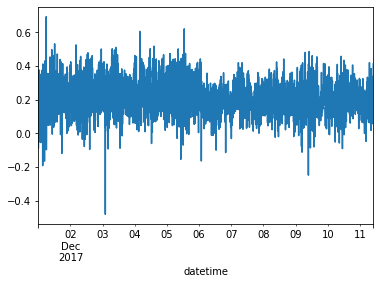

In [ ]:
df_5min['mean'].head(3000).plot()

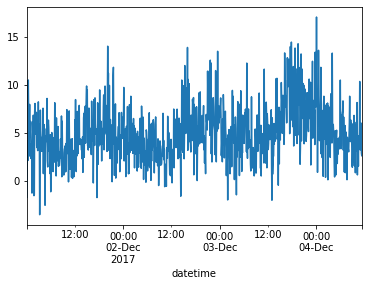

In [ ]:
df_5min['sum'].head(1000).plot()

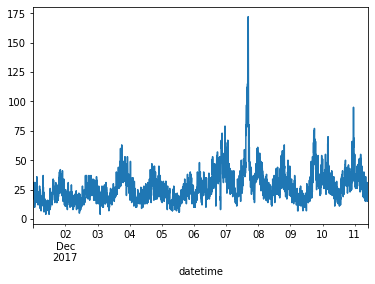

In [ ]:
df_5min['count'].head(3000).plot()

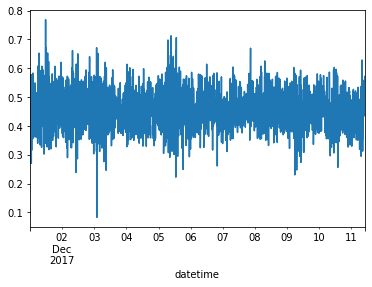

In [ ]:
df_5min['std'].head(3000).plot()